In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Max\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Max\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
data = pd.read_csv('BF_df_CTU.csv')
data.head()

,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
0,4,4,4,4,4,5,4,4,4,4,H
1,4,2,2,4,4,5,3,4,4,4,H
2,4,2,2,4,4,4,3,4,4,4,H
3,4,2,2,4,2,4,5,5,4,2,H
4,3,2,3,4,5,5,4,4,5,5,H


In [3]:
n,p = data.shape
x_real = data.iloc[:n//2,:-1]
x_fake = data.iloc[n//2:,:-1]

In [4]:
index = np.random.choice([0,1,2], size=n//2, p=[0.8,0.1,0.1])

x_real_train = x_real[index==0]
x_real_val = x_real[index==1]
x_real_test = x_real[index==2]

x_fake_train = x_fake[index==0]
x_fake_val = x_fake[index==1]
x_fake_test = x_fake[index==2]

# Exploratory analysis
In which way people are faking?
Let's plot some example of the true vs the fake responses of the same subject

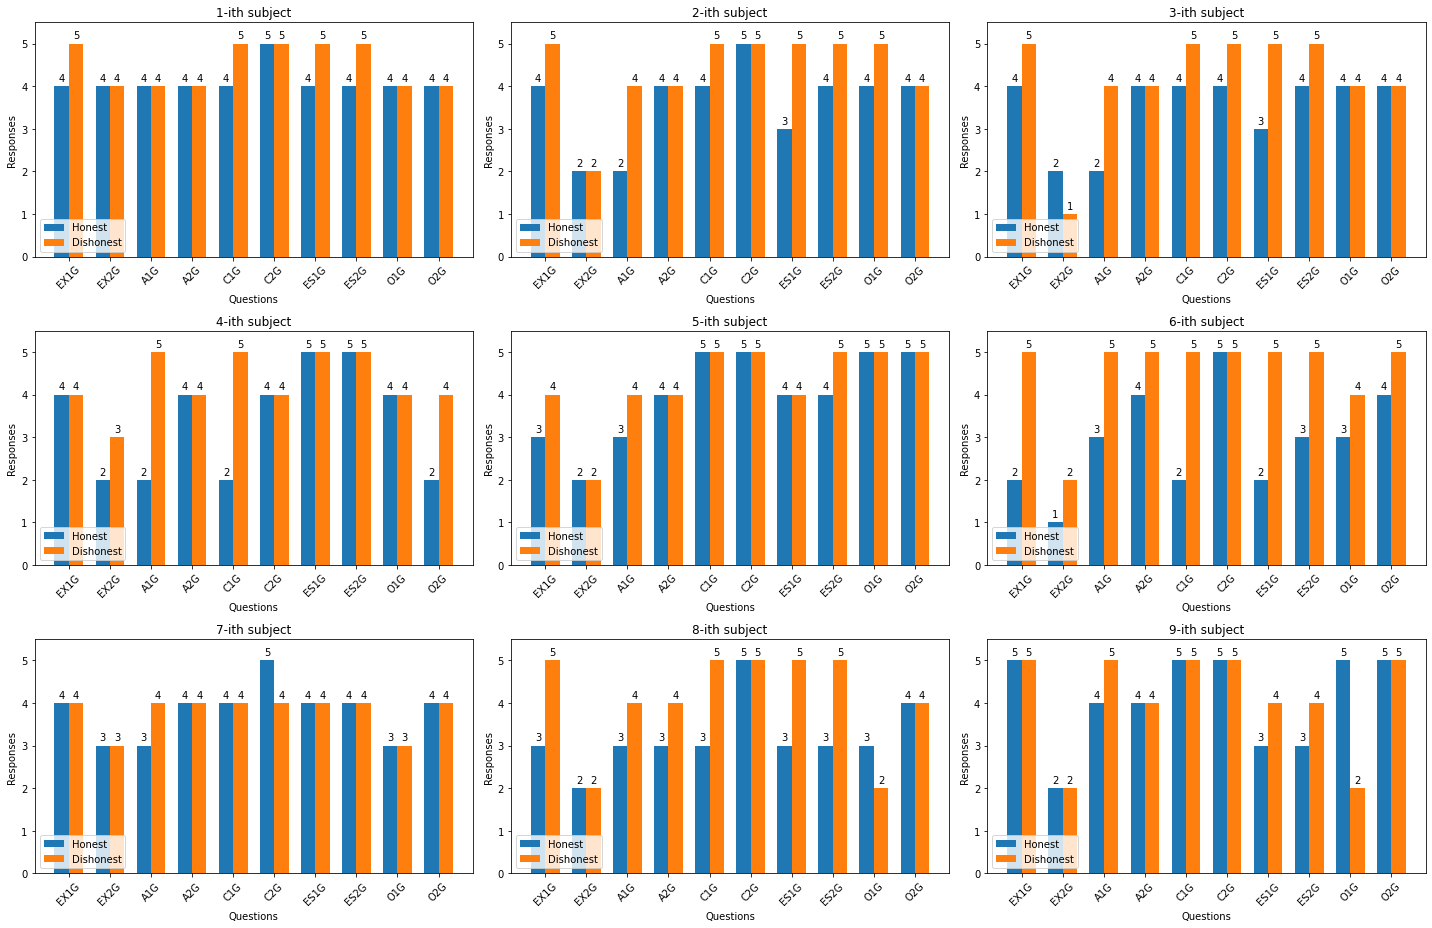

In [8]:
fig, ax = plt.subplots(3,3, figsize=(20, 13))

for i in range(9):

    row = int(i/3)
    col = i % 3

    labels = list(data.columns[:-1])

    honest = list(data.iloc[i,:-1])
    lier = list(data.iloc[n//2 + i,:-1])

    x = np.arange(len(labels))  
    width = 0.35  

    rects1 = ax[row, col].bar(x - width/2, honest, width, label='Honest')
    rects2 = ax[row, col].bar(x + width/2, lier, width, label='Dishonest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[row, col].set_title(str(i+1) + "-ith subject")
    ax[row, col].set_ylabel('Responses')
    ax[row, col].set_xlabel('Questions')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(labels, rotation=45)
    ax[row, col].legend(bbox_to_anchor=(0,0), loc="lower left")
    ax[row, col].set_ylim([0,5.5])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[row, col].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

fig.tight_layout()

plt.show()

### Now let's see the mean of the differences

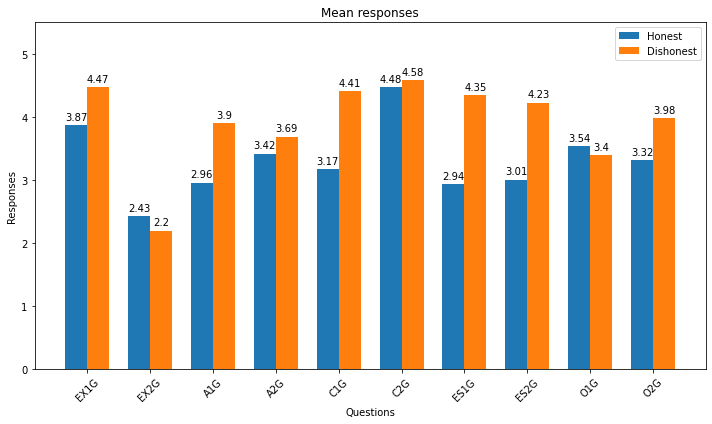

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

labels = list(data.columns[:-1])

honest = list(x_real.mean(0).round(2))
lier = list(x_fake.mean(0).round(2))

x = np.arange(len(labels))  
width = 0.35  

rects1 = ax.bar(x - width/2, honest, width, label='Honest')
rects2 = ax.bar(x + width/2, lier, width, label='Dishonest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Mean responses")
ax.set_ylabel('Responses')
ax.set_xlabel('Questions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(bbox_to_anchor=(1,1), loc="upper right")
ax.set_ylim([0,5.5])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Naive approach

All the proposed method should outperform the trivial strategy of subtracting to each subject faked response the average of the difference, across all subjects, among faked and honest response.

In [54]:
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)
test_mse = (((x_fake_test.subtract(mean_train)).to_numpy() - x_real_test.to_numpy())**2).mean()
test_mse

1.5545508843537414

# Denoising autoencoder

In [67]:
dim_1 = 10
dim_2 = 5

input_vector = tf.keras.layers.Input(shape=(10,))

# Define the encoder
hidden_1 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(input_vector)
encoded = tf.keras.layers.Dense(dim_2, activation='sigmoid')(hidden_1)

# ...and the decoder...
hidden_2 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(10, activation='linear')(hidden_2)

# and finally the autoencoder
autoencoder = tf.keras.models.Model(inputs=input_vector, outputs=decoded)

autoencoder.compile(optimizer='sgd', loss='mse')

In [68]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_22 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_23 (Dense)             (None, 10)                110       
Total params: 335
Trainable params: 335
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = autoencoder.fit(x_fake_train, x_real_train, epochs=200, shuffle=True, validation_data=(x_fake_val, x_real_val),  verbose = False)

In [70]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.legend(["Loss", "Val_loss"])
  plt.title('loss')

1/1 - 0s - loss: 1.1470
test mse: 1.14705


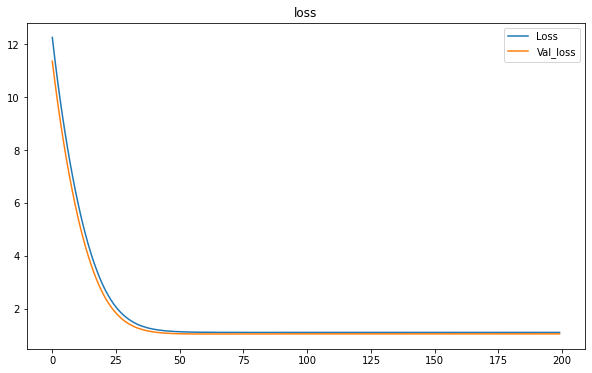

In [71]:
plot_loss(history)

scores = autoencoder.evaluate(x_fake_test, x_real_test, verbose=2)
print("test mse: %.5f" % (scores))

In [72]:
test_mse = ((autoencoder.predict(x_fake_test) - x_real_test.to_numpy())**2).mean()
test_mse

1.1470472351085048